# Applied Machine Learning Finance

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
import time
import itertools
import joblib

from jsonschema.exceptions import relevance
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier, LinearRegression
from courselib.models.nn import Sigmoid
from courselib.models.nn import MLP
from courselib.models.svm import BinaryKernelSVM
from courselib.models.svm import Kernel, RBFKernel, PolynomialKernel,LinearKernel
from courselib.utils.splits import train_test_split
from courselib.models.base import TrainableModel
from courselib.utils.metrics import binary_accuracy, mean_squared_error, mean_absolute_error,accuracy
from courselib.optimizers import GDOptimizer
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier
from courselib.utils.normalization import min_max
from courselib.models.glm import LogisticRegression
from courselib.models.base import TrainableModel
from courselib.utils.preprocessing import labels_encoding
from courselib.models.svm import LinearSVM
from courselib.models.svm import BinaryKernelSVM
from courselib.utils.metrics import cross_entropy
from courselib.utils.normalization import standardize
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif

In [7]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df



def compute_technical_indicators(data,amount,window):
    df = data.copy()

    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0).abs()
    avg_gain = up.ewm(window, adjust=False).mean()
    avg_loss = down.ewm(window, adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Daily_Return'] = df['Close'].pct_change()


    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()

    for i in range(amount):
        df[f'Lag_{i+1}'] = df['Daily_Return'].shift(i)

    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

def return_data(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Trend'] = df['Close'].rolling(window=5).mean().shift(-1) > df['Close']
    df['Target_01'] = np.where(df['Trend'], 1, 0)
    df['Target_-1'] = np.where(df['Trend'], 1, -1)
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test



In [8]:
def return_data_daily_return(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Target_Sign'] = np.sign(df['Close'].shift(-1) - df['Close']).shift(-1)
    df['Target_Sign_01'] = np.where(df['Target_Sign'] > 0, 1, 0)
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test, df


In [9]:
df = fetch_data('SPY', '2015-01-01', '2023-12-31')


C:\Users\Micha\AppData\Local\Temp\ipykernel_8520\1091297748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Prepare data
X, Y, X_train, Y_train, X_test, Y_test = return_data(df, target_type='Target_01', train_frac=0.8, features='whole')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

# Model setup
w = [0] * X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy_reg = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy_reg, 'MSE': mean_squared_error}

model_regression = LogisticRegression(w, b, optimizer)

# Train the model
metrics_history = model_regression.fit(
    X_train, Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)
joblib.dump((model_regression, metrics_history, X_test, Y_test, X, df), "regression_model_outputs.pkl")

['regression_model_outputs.pkl']

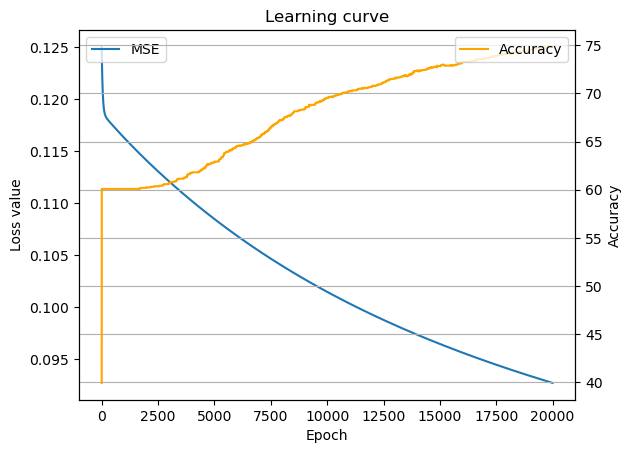

The final train accuracy: 74.83%
Test accuracy: 84.19%


In [ ]:
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")
# Plot learning curve
fig, ax = plt.subplots()
ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Learning curve')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.show()

# Evaluation
print(f'The final train accuracy: {metrics_history["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_reg(model_regression.decision_function(X_test), Y_test):.2f}%')



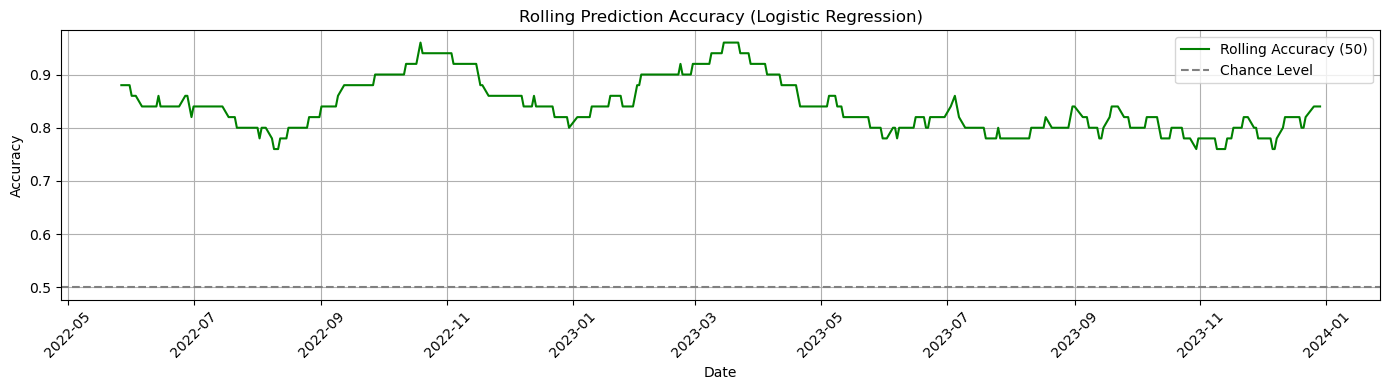

In [ ]:
# --- Rolling window accuracy plot (with real dates) ---
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")
# Extract aligned dates from original df
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# Use same logic to align Date with test set
date_series = df_copy['Date'].iloc[-len(X):].values
split_idx = int(len(X) * 0.8)
test_dates = date_series[split_idx:]

# Predictions
Y_pred = model_regression(X_test)
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_test,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Plot
plt.figure(figsize=(14, 4))
plt.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
plt.title('Rolling Prediction Accuracy (Logistic Regression)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
X, Y, X_train, Y_train, X_test, Y_test= return_data(df,target_type='Target_-1',train_frac=.8,features='whole')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
kernels = ['linear', 'polynomial', 'rbf']
for i in range(10):
    start = time.time()
    svm_poly = BinaryKernelSVM(kernel='polynomial', degree=i)
    svm_poly.fit(X_train, Y_train)
    end = time.time()

    test_acc = binary_accuracy(svm_poly(X_test), Y_test)

    train_acc = binary_accuracy(svm_poly(X_train), Y_train)

    print(f'Test accuracy degree {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")

sigma_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
for i in sigma_values:
    start = time.time()
    svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=i)
    svm_rbf.fit(X_train, Y_train)
    end = time.time()

    test_acc = binary_accuracy(svm_rbf(X_test), Y_test)

    train_acc = binary_accuracy(svm_rbf(X_train), Y_train)

    print(f'Test accuracy sigma {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")


Test accuracy degree 0: 55.0111, Train accuracy: 60.0780
⏱️ Train time: 5.8095 seconds
Test accuracy degree 1: 68.3742, Train accuracy: 84.1871
⏱️ Train time: 12.9738 seconds
Test accuracy degree 2: 55.9020, Train accuracy: 90.1448
⏱️ Train time: 14.8460 seconds
Test accuracy degree 3: 55.6793, Train accuracy: 91.9265
⏱️ Train time: 15.5811 seconds
Test accuracy degree 4: 54.7884, Train accuracy: 92.6503
⏱️ Train time: 15.1113 seconds
Test accuracy degree 5: 57.9065, Train accuracy: 92.9844
⏱️ Train time: 13.2352 seconds
Test accuracy degree 6: 61.9154, Train accuracy: 94.1537
⏱️ Train time: 14.4062 seconds
Test accuracy degree 7: 61.9154, Train accuracy: 94.7105
⏱️ Train time: 15.3888 seconds
Test accuracy degree 8: 57.6837, Train accuracy: 88.4744
⏱️ Train time: 19.5136 seconds
Test accuracy degree 9: 59.4655, Train accuracy: 91.8151
⏱️ Train time: 19.8551 seconds
Test accuracy sigma 0.01: 55.0111, Train accuracy: 100.0000
⏱️ Train time: 7.8810 seconds
Test accuracy sigma 0.05: 55.01

Test accuracy sigma 1: 74.3875, Train accuracy: 82.9621


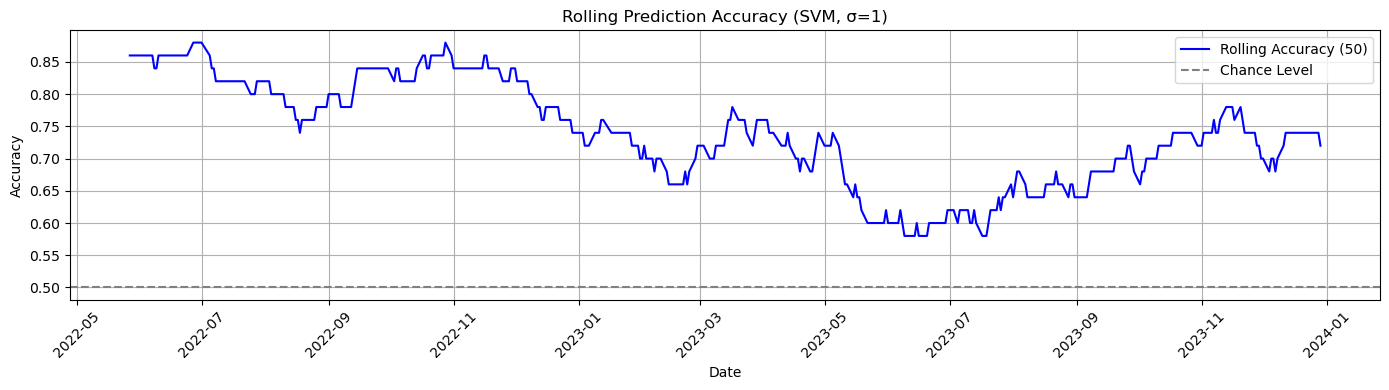

In [ ]:
# Prepare data
X, Y, X_train, Y_train, X_test, Y_test = return_data(df, target_type='Target_-1', train_frac=0.8, features='whole')
X_train = min_max(X_train)
X_test = min_max(X_test)
X = min_max(X)

# Train model
svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=1)
svm_rbf.fit(X_train, Y_train)

# Evaluate
test_acc = binary_accuracy(svm_rbf(X_test), Y_test)
train_acc = binary_accuracy(svm_rbf(X_train), Y_train)

print(f'Test accuracy sigma {1}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

# --- Rolling accuracy visualization ---

# Get the corresponding dates from the original df
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()  # Ensure 'Date' is a column
df_copy.dropna(inplace=True)

# Align dates with final feature set
date_series = df_copy['Date'].iloc[-len(X):].values
split_idx = int(len(X) * 0.8)
test_dates = date_series[split_idx:]

# Predictions
Y_pred = svm_rbf(X_test)
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_test,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Plot
plt.figure(figsize=(14, 4))
plt.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='blue', label='Rolling Accuracy (50)')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
plt.title('Rolling Prediction Accuracy (SVM, σ=1)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_-1',train_frac=.8)
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

Y, Y_train, Y_test = labels_encoding(Y), labels_encoding(Y_train), labels_encoding(Y_test)

metrics_dict = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}


optimizer = GDOptimizer(learning_rate=1)

model = MLP(widths=[14, 64,32, 2], optimizer=optimizer, activation='ReLU', output_activation='Linear', loss='MSE')

metrics_history = model.fit(X_train, Y_train, num_epochs=15000, batch_size=len(X_train), compute_metrics=True,
                            metrics_dict=metrics_dict)

joblib.dump((model, metrics_history, X_test, Y_test, X, df), "mlp_model_outputs.pkl")



['mlp_model_outputs.pkl']

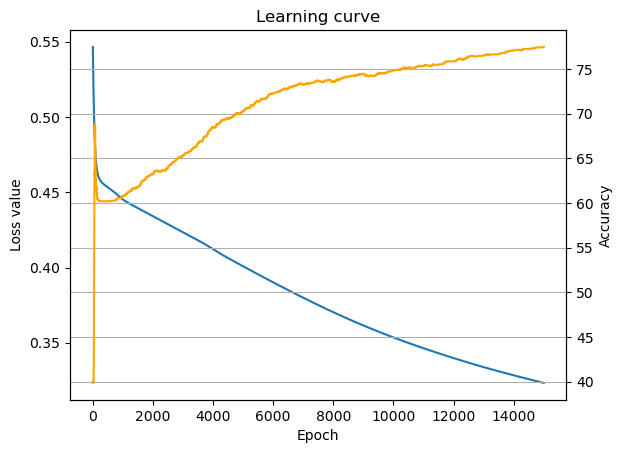

The final train accuracy: 77.4%
Test accuracy: 80.6%


In [ ]:
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("mlp_model_outputs.pkl")
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()
plt.show()

print(f'The final train accuracy: {round(metrics_history["accuracy"][-1], 1)}%')
print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), Y_test), 1)}%')



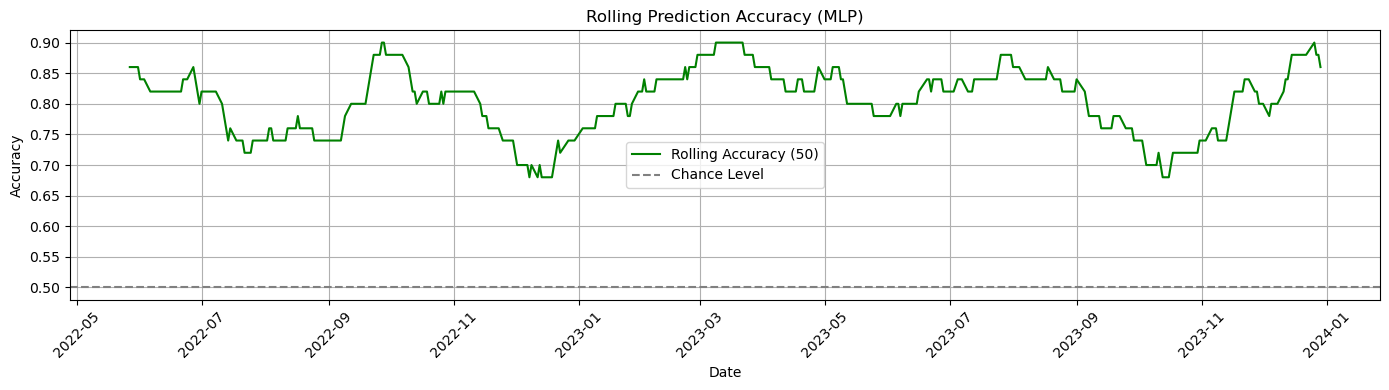

In [ ]:
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("mlp_model_outputs.pkl")
Y_pred = model(X_test)

# Convert predictions to class labels (assuming sigmoid-like output around 0)
if Y_pred.ndim == 1 or Y_pred.shape[1] == 1:
    Y_pred_labels = (Y_pred > 0).astype(int).flatten()
    Y_true_labels = Y_test.flatten() if Y_test.ndim == 1 else Y_test.argmax(axis=1)
else:
    # Multiclass (e.g. shape [n_samples, 2])
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_test, axis=1)
    


# Get test dates
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# Extract test dates
test_dates = df_copy['Date'].iloc[-len(X_test):].values

# Build result DataFrame
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Plot
plt.figure(figsize=(14, 4))
plt.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
plt.title('Rolling Prediction Accuracy (MLP)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
X, Y, X_train, Y_train, X_test, Y_test = return_data(df,target_type='Target_01',train_frac=.8,features = 'lagged')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)
w = [0] * X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy, 'MSE': mean_squared_error}

model = LinearRegression(w, b, optimizer)

metrics_history = model.fit(
    X_train, Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)

joblib.dump((model, metrics_history, X_test, Y_test, X, df), "lag_model_outputs.pkl")

['lag_model_outputs.pkl']

Final train accuracy (baseline): 67.00%
Test accuracy (baseline): 71.68%


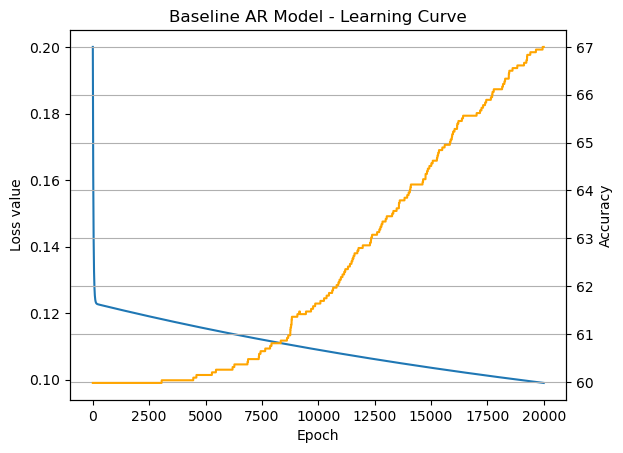

In [ ]:
# Plot metrics
model, metrics_history, X_test, Y_test, X_full, df = joblib.load("lag_model_outputs.pkl")
fig, ax = plt.subplots()
ax.plot(metrics_history['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax.set_xlabel('Epoch')
ax2 = ax.twinx()
ax2.plot(metrics_history['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
plt.title('Baseline AR Model - Learning Curve')
plt.grid()

# Final metrics
train_acc = metrics_history["accuracy"][-1]
test_acc = accuracy(model.decision_function(X_test), Y_test)

print(f'Final train accuracy (baseline): {train_acc :.2f}%')
print(f'Test accuracy (baseline): {test_acc :.2f}%')

plt.show()

# Daily Return Analysis and Trading Strategies

# RBF SVM

Model Training

In [94]:
data = fetch_data('SPY', '2015-01-01', '2025-12-31')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)


C:\Users\Micha\AppData\Local\Temp\ipykernel_8520\1091297748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [95]:
rbf_svm = BinaryKernelSVM(kernel='rbf',sigma = 0.3)
metrics_history = rbf_svm.fit(X_train,Y_train)
binary_acc = binary_accuracy(rbf_svm(X_train), Y_train)

In [96]:
y_pred_test = rbf_svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)



Test Accuracy: 58.285714285714285


Trading Strategy with RBF SVM

In [97]:
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]

data['rbf_svm_pred'] = np.nan
data.loc[test_indices, 'rbf_svm_pred'] = y_pred_test
data['rbf_svm_pred'] = data['rbf_svm_pred'].shift(1)
data.dropna(inplace=True)
print(data[data['rbf_svm_pred'] == -1].count())
print(data[data['rbf_svm_pred'] == 1].count())

Price
Date               20
SMA_14             20
EMA_14             20
RSI_14             20
Bollinger_Upper    20
Bollinger_Lower    20
MACD               20
MACD_Signal        20
Daily_Return       20
Rolling_5d_Std     20
Lag_1              20
Lag_2              20
Lag_3              20
Momentum_10        20
Target_Sign        20
Close              20
rbf_svm_pred       20
dtype: int64
Price
Date               504
SMA_14             504
EMA_14             504
RSI_14             504
Bollinger_Upper    504
Bollinger_Lower    504
MACD               504
MACD_Signal        504
Daily_Return       504
Rolling_5d_Std     504
Lag_1              504
Lag_2              504
Lag_3              504
Momentum_10        504
Target_Sign        504
Close              504
rbf_svm_pred       504
dtype: int64


In [98]:
data['strategy_return'] = data['Daily_Return'] * data['rbf_svm_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", data['cumulative_strategy'].iloc[-1])
print("asset return is", data['cumulative_asset'].iloc[-1])


strategy return is 1.460791094146752
asset return is 1.49377696485667


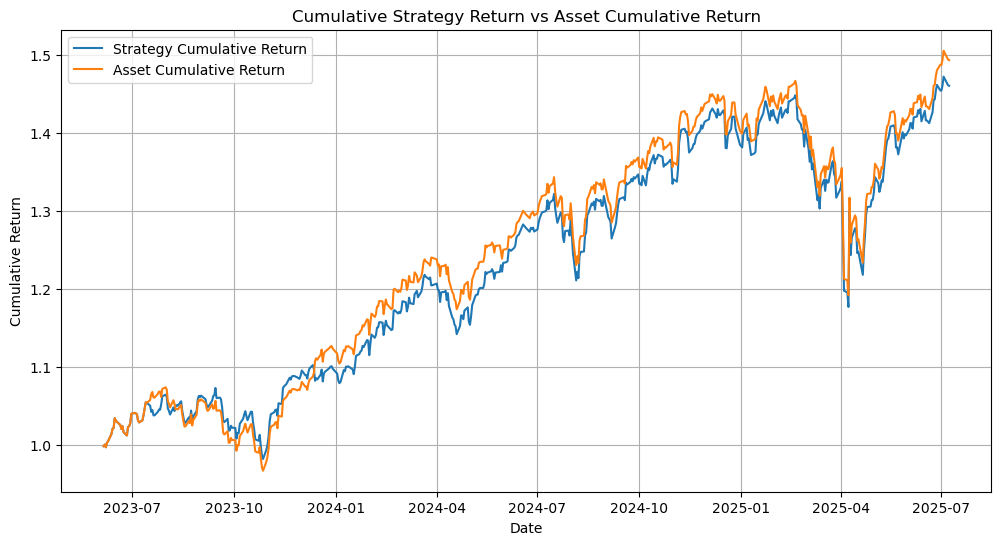

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
data = fetch_data('TSLA', '2015-01-01', '2025-12-31')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)
data

C:\Users\Micha\AppData\Local\Temp\ipykernel_8520\1091297748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


Price,Date,SMA_14,EMA_14,RSI_14,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Target_Sign,Close
19,2015-01-30,13.315238,13.537827,23.208257,14.545204,12.555530,-0.212373,-0.282948,-0.007797,0.025514,-0.007797,0.029242,-0.032091,0.782000,1.0,13.573333
20,2015-02-02,13.356809,13.607805,30.446510,14.417178,12.627755,-0.152993,-0.256957,0.036051,0.028064,0.036051,-0.007797,0.029242,1.191334,1.0,14.062667
21,2015-02-03,13.424000,13.734409,36.889544,14.536720,12.563347,-0.065267,-0.218619,0.035176,0.030613,0.035176,0.036051,-0.007797,1.762000,1.0,14.557333
22,2015-02-04,13.547143,13.845821,37.049532,14.637173,12.511361,0.005219,-0.173852,0.000870,0.020638,0.000870,0.035176,0.036051,1.465333,-1.0,14.570000
23,2015-02-05,13.685809,13.964067,39.171273,14.772723,12.442743,0.073359,-0.124409,0.011165,0.019901,0.011165,0.000870,0.035176,1.291334,1.0,14.732667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2638,2025-07-01,324.644283,322.750694,42.251161,352.912630,290.672365,-0.100425,2.934180,-0.053359,0.020828,-0.053359,-0.018447,-0.006600,-28.420013,-1.0,300.709991
2639,2025-07-02,323.874283,321.803934,48.031474,349.711419,291.011576,-0.613964,2.224551,0.049682,0.037066,0.049682,-0.053359,-0.018447,-0.700012,-1.0,315.649994
2640,2025-07-03,323.605713,320.943410,47.928266,348.422992,290.630005,-1.033244,1.572992,-0.000950,0.037162,-0.000950,0.049682,-0.053359,-6.699982,1.0,315.350006
2641,2025-07-07,321.364999,317.342956,41.164490,346.757689,293.219307,-3.057886,0.646816,-0.067893,0.046398,-0.067893,-0.000950,0.049682,-28.220001,-1.0,293.940002


In [104]:
y_pred_test = rbf_svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)


Test Accuracy: 50.095238095238095


In [105]:
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]

data['rbf_svm_pred'] = np.nan
data.loc[test_indices, 'rbf_svm_pred'] = y_pred_test
data['rbf_svm_pred'] = data['rbf_svm_pred'].shift(1)
data.dropna(inplace=True)
print(data[data['rbf_svm_pred'] == -1].count())
print(data[data['rbf_svm_pred'] == 1].count())

Price
Date               8
SMA_14             8
EMA_14             8
RSI_14             8
Bollinger_Upper    8
Bollinger_Lower    8
MACD               8
MACD_Signal        8
Daily_Return       8
Rolling_5d_Std     8
Lag_1              8
Lag_2              8
Lag_3              8
Momentum_10        8
Target_Sign        8
Close              8
rbf_svm_pred       8
dtype: int64
Price
Date               516
SMA_14             516
EMA_14             516
RSI_14             516
Bollinger_Upper    516
Bollinger_Lower    516
MACD               516
MACD_Signal        516
Daily_Return       516
Rolling_5d_Std     516
Lag_1              516
Lag_2              516
Lag_3              516
Momentum_10        516
Target_Sign        516
Close              516
rbf_svm_pred       516
dtype: int64


In [106]:
data['strategy_return'] = data['Daily_Return'] * data['rbf_svm_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", data['cumulative_strategy'].iloc[-1])
print("asset return is", data['cumulative_asset'].iloc[-1])


strategy return is 1.1756608384948986
asset return is 1.3918306111117535


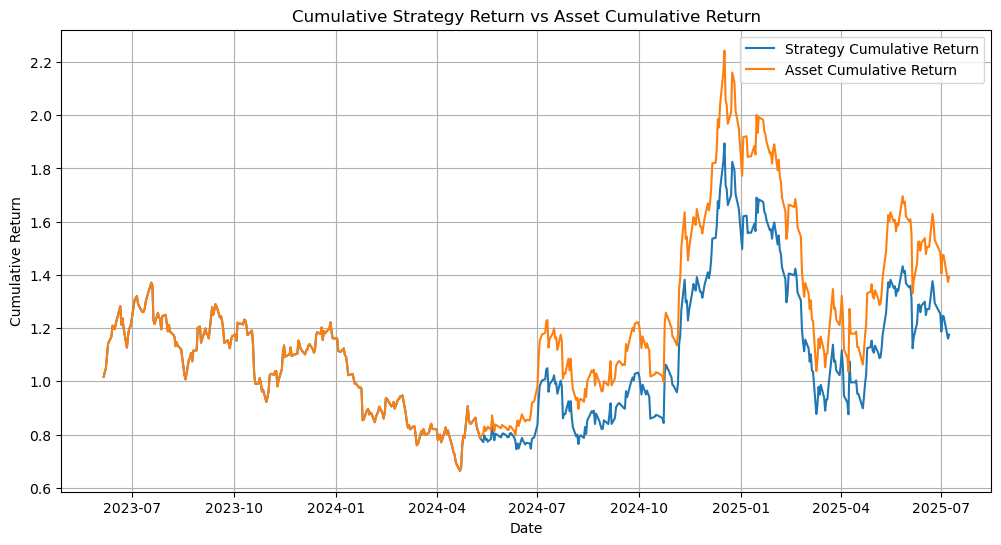

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Logistic Regression

In [ ]:
data = fetch_data('SPY', '2015-01-01', '2025-12-31')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign_01', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)

C:\Users\Micha\AppData\Local\Temp\ipykernel_36844\1091297748.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [ ]:
w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[0, 1]), 
                "loss": lambda y_pred, y_true: cross_entropy(y_pred, y_true)}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [ ]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 58.0952380952381


Trading Strategy with Logistic Regression

In [ ]:
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]

data['logistic_pred'] = np.nan
data.loc[test_indices, 'logistic_pred'] = y_pred_test
data['logistic_pred'] = data['logistic_pred'].shift(1)
data.dropna(inplace=True)
data['logistic_pred'].replace(0, -1, inplace=True)

C:\Users\Micha\AppData\Local\Temp\ipykernel_36844\2700328995.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['logistic_pred'].replace(0, -1, inplace=True)


In [ ]:
data['strategy_return'] = data['Daily_Return'] * data['logistic_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", data['cumulative_strategy'].iloc[-1])
print("asset return is", data['cumulative_asset'].iloc[-1])


strategy return is 1.4603146169848897
asset return is 1.5065855773142167


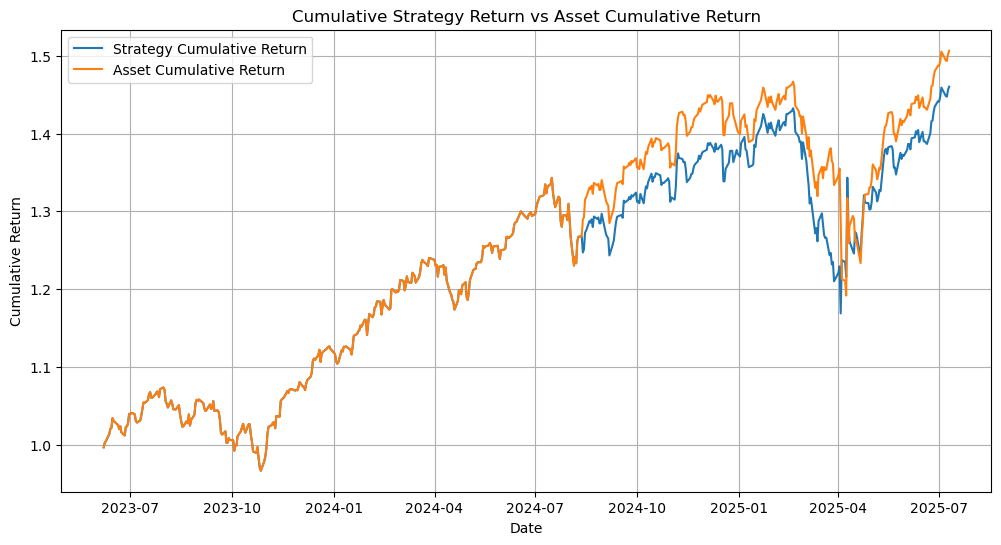

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()